<a href="https://colab.research.google.com/github/veyselalevcan/Federated-Learning-and-Generative-AI/blob/main/SWaT_July2019_FL_Anomaly_Detection_and_GAN_Fake_Injection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 ADVANCED ANOMALY DETECTION SYSTEM

📥 Loading data...

🌐 FEDERATED CLIENT ANALYSIS

🔍 Evaluating Clients...

📊 Client 1 Results:
Samples: 397
Mean MSE: 0.1109
Median MSE: 0.0999

📊 Client 2 Results:
Samples: 396
Mean MSE: 0.1157
Median MSE: 0.1030

📊 Client 3 Results:
Samples: 396
Mean MSE: 0.1098
Median MSE: 0.0993

📊 Client 4 Results:
Samples: 396
Mean MSE: 0.1170
Median MSE: 0.1049

📊 Client 5 Results:
Samples: 396
Mean MSE: 0.1103
Median MSE: 0.0959

🔧 Optimized Threshold: 0.2847

🤖 GAN ATTACK ANALYSIS

🔨 Training Autoencoder...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 2.8727 - val_loss: 1.0481 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3273 - val_loss: 0.8933 - learning_rate: 1.0000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.0087 - val_loss: 0.8054 - learning_rate: 1.0000e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8229 - val_loss: 0.7431 - learning_rate: 1.0000e-04
Epoch 5/

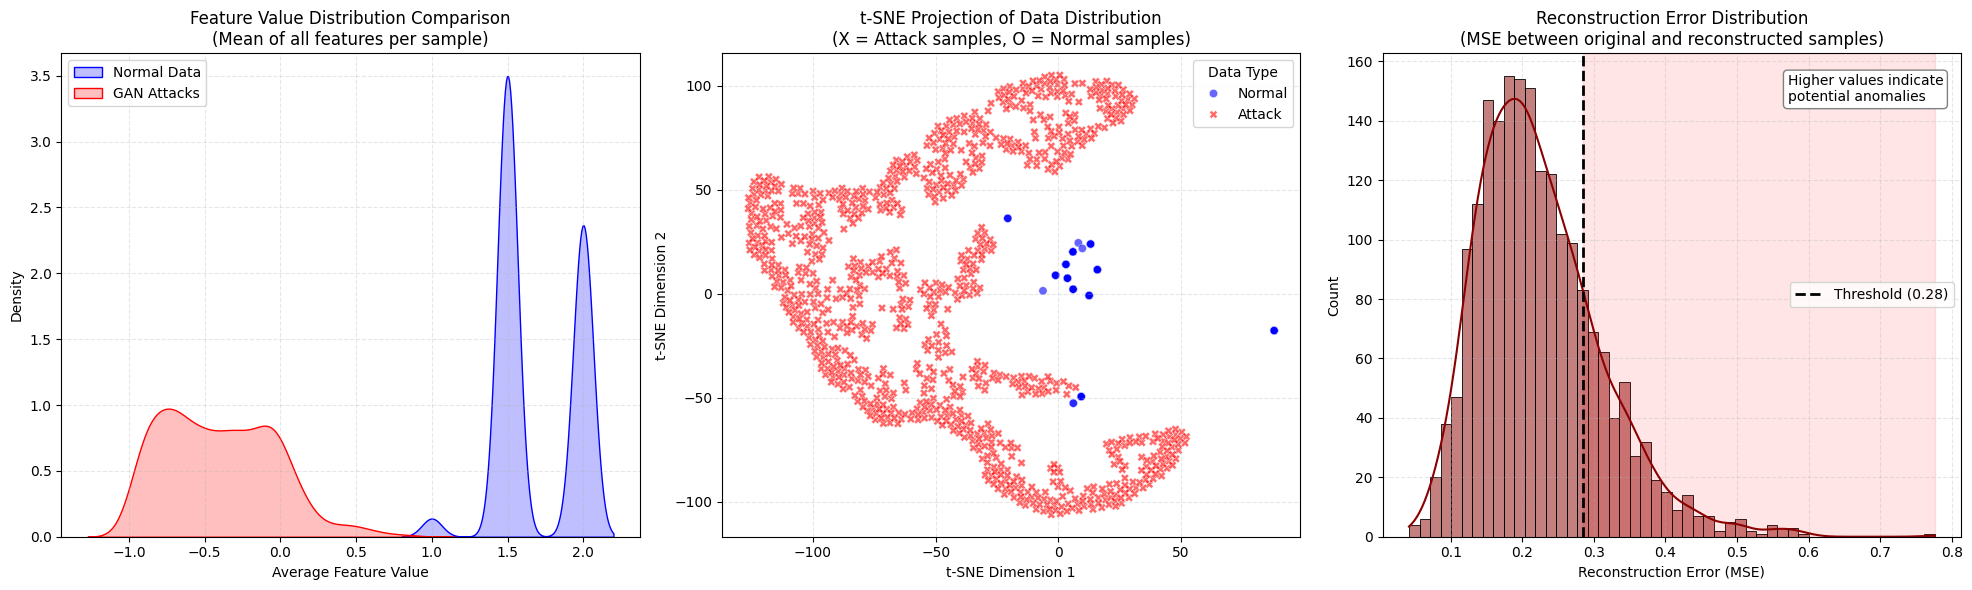


✅ All analyses completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ========== 1. ENHANCED AUTOENCODER MODEL ==========
def build_enhanced_autoencoder(input_dim):
    """Builds a deep autoencoder model with improved architecture"""
    inp = Input(shape=(input_dim,))

    # Encoder
    x = Dense(512, activation='swish', kernel_initializer='he_normal')(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='swish', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Bottleneck
    encoded = Dense(32, activation='swish', kernel_initializer='he_normal')(x)

    # Decoder
    x = Dense(256, activation='swish', kernel_initializer='he_normal')(encoded)
    x = BatchNormalization()(x)
    x = Dense(512, activation='swish', kernel_initializer='he_normal')(x)
    x = Dropout(0.3)(x)

    out = Dense(input_dim, activation='linear')(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# ========== 2. DATA PROCESSING FUNCTIONS ==========
def load_and_preprocess_data():
    """Loads and preprocesses all required datasets"""
    try:
        # Load client data
        clients_data = []
        for i in range(5):
            client_data = np.load(f"/content/clients_data/client_{i}_data.npy", allow_pickle=True)
            clients_data.append((client_data, client_data))  # Autoencoder uses same input/output

        # Load global model
        global_model = tf.keras.models.load_model(
            "/content/global_ae_model.h5",
            custom_objects={'mse': MeanSquaredError()}
        )

        # Load and preprocess GAN data
        df_gan = pd.read_csv("/content/generated_attack_data.csv")
        gan_data = preprocess_gan_data(df_gan.values.astype(float))

        # Load and preprocess real data (SWaT dataset)
        df_real = pd.read_csv(
            '/content/SWaT_dataset_Jul 19 v2.csv',
            sep=';',
            skiprows=1,
            low_memory=False
        )
        df_real = clean_and_prepare_real_data(df_real)

        return clients_data, global_model, gan_data, df_real, df_gan

    except Exception as e:
        print(f"Data loading error: {str(e)}")
        return None, None, None, None, None

def preprocess_gan_data(data):
    """Preprocesses GAN-generated attack data"""
    scaler = RobustScaler()
    data = scaler.fit_transform(data)
    data = np.clip(data, -3, 3)  # Clip extreme values
    return np.nan_to_num(data)

def clean_and_prepare_real_data(df):
    """Cleans and prepares the real SWaT dataset"""
    # Clean column names
    df.columns = [col.strip().upper().replace(' ', '_') for col in df.columns]

    # Select only numeric columns
    numeric_cols = []
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='raise')
            numeric_cols.append(col)
        except:
            continue

    return df[numeric_cols]

# ========== 3. ANALYSIS FUNCTIONS ==========
def evaluate_clients(clients_data, model):
    """Evaluates client models and determines threshold"""
    try:
        print("\n🔍 Evaluating Clients...")
        all_mse = []

        for i, (x_test, y_test) in enumerate(clients_data):
            y_pred = model.predict(x_test, verbose=0)
            mse = np.mean((y_test - y_pred) ** 2, axis=1)
            all_mse.extend(mse)

            print(f"\n📊 Client {i+1} Results:")
            print(f"Samples: {len(x_test)}")
            print(f"Mean MSE: {np.mean(mse):.4f}")
            print(f"Median MSE: {np.median(mse):.4f}")

        # Optimized threshold determination
        threshold = optimize_threshold(all_mse, sensitivity=0.85)
        print(f"\n🔧 Optimized Threshold: {threshold:.4f}")

        return threshold

    except Exception as e:
        print(f"Client evaluation error: {str(e)}")
        return 0.1

def optimize_threshold(mse_scores, sensitivity=0.9):
    """Calculates optimized threshold based on MSE distribution"""
    q75 = np.quantile(mse_scores, 0.75)
    iqr = np.quantile(mse_scores, 0.75) - np.quantile(mse_scores, 0.25)
    base_threshold = q75 + 1.5 * iqr
    return base_threshold * (1 + (1 - sensitivity))

def analyze_gan_attacks(ae_model, threshold, gan_data):
    """Analyzes GAN-generated attack data"""
    try:
        print("\n🔍 Analyzing GAN Attacks...")

        recon = ae_model.predict(gan_data, verbose=0)
        mse = np.mean((gan_data - recon) ** 2, axis=1)

        # Detailed statistics
        stats = {
            'mean': np.mean(mse),
            'median': np.median(mse),
            'max': np.max(mse),
            'min': np.min(mse),
            'std': np.std(mse),
            'anomaly_ratio': np.mean(mse > threshold)
        }

        print("\n🎯 GAN Attack Analysis Results:")
        for k, v in stats.items():
            unit = '' if k == 'anomaly_ratio' else ' MSE'
            print(f"{k.upper()}: {v:.4f}{unit}" if isinstance(v, float) else f"{k.upper()}: {v}")

        return mse, stats

    except Exception as e:
        print(f"GAN analysis error: {str(e)}")
        return None, None

# ========== 4. ENHANCED VISUALIZATION ==========
def enhanced_visualization(df_real, df_gan, mse_gan=None, threshold=None):
    """Generates enhanced visualizations with clear explanations"""
    try:
        # Sample equal number of points (max 1000)
        n_samples = min(len(df_real), len(df_gan), 1000)
        df_real = df_real.sample(n_samples, random_state=42)
        df_gan = df_gan.sample(n_samples, random_state=42)

        # Find common columns
        common_cols = list(set(df_real.columns) & set(df_gan.columns))
        if not common_cols:
            print("⚠️ No common columns found - visualization skipped")
            return

        plt.figure(figsize=(20, 6))

        # 1. Feature Distribution Comparison
        plt.subplot(1, 3, 1)
        sns.kdeplot(df_real[common_cols].mean(axis=1),
                   label='Normal Data', fill=True, color='blue')
        sns.kdeplot(df_gan[common_cols].mean(axis=1),
                   label='GAN Attacks', fill=True, color='red')
        plt.title('Feature Value Distribution Comparison\n(Mean of all features per sample)')
        plt.xlabel('Average Feature Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)

        # 2. TSNE Visualization
        plt.subplot(1, 3, 2)
        X = np.vstack([df_real[common_cols].values, df_gan[common_cols].values])
        y = np.array(['Normal']*len(df_real) + ['Attack']*len(df_gan))

        tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(
            StandardScaler().fit_transform(X))

        sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=y,
                       palette={'Normal':'blue', 'Attack':'red'},
                       alpha=0.6, style=y, markers={'Normal':'o', 'Attack':'X'})
        plt.title('t-SNE Projection of Data Distribution\n(X = Attack samples, O = Normal samples)')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.legend(title='Data Type')
        plt.grid(True, linestyle='--', alpha=0.3)

        # 3. Reconstruction Error Distribution
        if mse_gan is not None:
            plt.subplot(1, 3, 3)
            ax = sns.histplot(mse_gan, bins=50, kde=True, color='darkred')

            if threshold:
                plt.axvline(threshold, color='black', linestyle='--',
                           linewidth=2, label=f'Threshold ({threshold:.2f})')
                plt.axvspan(threshold, np.max(mse_gan), color='red', alpha=0.1)

            plt.title('Reconstruction Error Distribution\n(MSE between original and reconstructed samples)')
            plt.xlabel('Reconstruction Error (MSE)')
            plt.ylabel('Count')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.3)

            # Add annotation for interpretation
            plt.annotate('Higher values indicate\npotential anomalies',
                        xy=(0.7, 0.9), xycoords='axes fraction',
                        bbox=dict(boxstyle='round', fc='white', ec='gray'))

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Visualization error: {str(e)}")

# ========== 5. MAIN PIPELINE ==========
def main_pipeline():
    print("="*60)
    print("🚀 ADVANCED ANOMALY DETECTION SYSTEM")
    print("="*60)

    # 1. Data Loading
    print("\n📥 Loading data...")
    clients_data, global_model, gan_data, df_real, df_gan = load_and_preprocess_data()
    if clients_data is None:
        return

    # 2. Client Evaluation
    print("\n" + "="*60)
    print("🌐 FEDERATED CLIENT ANALYSIS")
    print("="*60)
    threshold = evaluate_clients(clients_data, global_model)

    # 3. Autoencoder Training
    print("\n" + "="*60)
    print("🤖 GAN ATTACK ANALYSIS")
    print("="*60)

    input_dim = clients_data[0][0].shape[1]
    ae_model = build_enhanced_autoencoder(input_dim)

    X_train = np.vstack([x for x, _ in clients_data])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    print("\n🔨 Training Autoencoder...")
    history = ae_model.fit(
        X_train, X_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # 4. GAN Attack Analysis
    mse_gan, stats = analyze_gan_attacks(ae_model, threshold, gan_data)

    # 5. Enhanced Visualization
    print("\n" + "="*60)
    print("📊 DATA VISUALIZATION")
    print("="*60)
    enhanced_visualization(df_real, df_gan, mse_gan, threshold)

    print("\n✅ All analyses completed successfully!")

if __name__ == "__main__":
    main_pipeline()